In [16]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [17]:
from numpy import loadtxt
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches

Betöltöm a kontinuum PCA együtthatókat

In [18]:
PCs=numpy.load('./PCAfeldolgozas/PCs.npy')

Betöltöm az emissziós PCA együtthatókat

In [19]:
PCemiss=numpy.load('./PCAfeldolgozas/PCsemiss.npy')

A fehérítés lépést nem szabad kifelejteni

In [20]:
eig5=numpy.load('./PCAfeldolgozas/eig5.npy')

In [21]:
szorasok=numpy.std(eig5,axis=1)
print(szorasok)

[ 0.01396447  0.01205188  0.01402049  0.01389697  0.01394858]


In [22]:
PCsfeher=numpy.empty((5,13787))
for j in range (0,5):
    for i in range (0,13787):
        PCsfeher[j,i]=PCs[j,i]/szorasok[j]

In [23]:
PCsfehT=PCsfeher.T

Elvégzem újra erre a 40-es klaszterezést

In [24]:
kmeans=KMeans(n_clusters=40).fit(PCsfehT)
labels40=kmeans.labels_
centr40=kmeans.cluster_centers_

In [25]:
numpy.save('./PCAfeldolgozas/finlabels40.npy',labels40)
numpy.save('./PCAfeldolgozas/fincenters40.npy',centr40)

In [26]:
atlagsp=numpy.load('./PCAfeldolgozas/atlagspektrum.npy')
labels40=numpy.load('./PCAfeldolgozas/finlabels40.npy')
centr40=numpy.load('./PCAfeldolgozas/fincenters40.npy')

A sajátspektrumok már megvannak, ki kell fejteni a bemeneti templatet ezen a bázison, majd meg kell nézni melyik centroidhoz esik a legközelebb

# Template kifejtése a PCA térben

In [27]:
spektra={}
content=loadtxt('./SDSS/Composites/Tblu1.txt')
kompozit=content[:,[0,4]]
spektra[0]=kompozit
i=1

In [28]:
eig=eig5.T

Le kell normálni a kompozitot, itt igazából csak azt csinálom, amit a PCAKifejtes programban

In [29]:
for j in range (0,i):
    temp=spektra[j]
    m1=0
    m2=0
    m3=0
    m4=0
    n=0
    for k in temp[:,0]:
        if(k>4250 and k<4300):
            if(m1==0):
                normalashoz1=temp[n,1]
                m1+=1
            else:
                normalashoz1=numpy.append(normalashoz1,temp[n,1])
                
        if(k>4600 and k<4800):
            if(m2==0):
                normalashoz2=temp[n,1]
                m2+=1
            else:
                normalashoz2=numpy.append(normalashoz2,temp[n,1])
                
        if(k>5400 and k<5500):
            if(m3==0):
                normalashoz3=temp[n,1]
                m3+=1
            else:
                normalashoz3=numpy.append(normalashoz3,temp[n,1])
                
        if(k>5600 and k<5800):
            if(m4==0):
                normalashoz4=temp[n,1]
                m4+=1
            else:
                normalashoz4=numpy.append(normalashoz4,temp[n,1])
                
        n+=1
        
    med1=numpy.median(normalashoz1)
    med2=numpy.median(normalashoz2)
    med3=numpy.median(normalashoz3)
    med4=numpy.median(normalashoz4)
    avgmed=(med1+med2+med3+med4)/4
        
    temp[:,1]=temp[:,1]/avgmed
    spektra[j]=temp
    del temp

Most újra kell mintavételeznem, most még ugyanakkora tartományra mint amin a PCA is futott, ez a kifejtési együtthatókhoz kell, később nem ezzel az újramintavételezettel fogok dolgozni

In [30]:
def interpol(x1,x2,y1,y2,xk):
    a=(y2-y1)/(x2-x1)
    b=y1-x1*(y2-y1)/(x2-x1)
    
    yx=a*xk+b
    
    return(yx)

In [31]:
mintapontok=linspace(3724,6760.6,5062)
nullak=linspace(0,0,5062)

In [32]:
umspektra={}          # ezt a példányt meghagyom a mintavételezésre, bár gyorsabb lenne a nyumpy-os interpoláció
for j in range (0,i):
    umspektrum=numpy.vstack((mintapontok,nullak)).T
    temp=spektra[j]
    v=0
    w=0
    for q in range (0,5062):
        xk=mintapontok[q]
        while(temp[w,0]<6760.6):
            if(xk>temp[w,0] and xk<temp[w+1,0]):
                yk=interpol(temp[w,0],temp[w+1,0],temp[w,1],temp[w+1,1],xk)
                umspektrum[v,0]=xk
                umspektrum[v,1]=yk
                v+=1
                break
            if(xk==temp[w,0]):
                umspektrum[v,0]=xk
                umspektrum[v,1]=temp[w,1]
                v+=1
                break
            if(xk==temp[w+1,0]):
                umspektrum[v,0]=xk
                umspektrum[v,1]=temp[w+1,1]
                v+=1
                break
            w+=1
    del temp
    umspektra[j]=umspektrum
    del umspektrum

(3700, 6500)

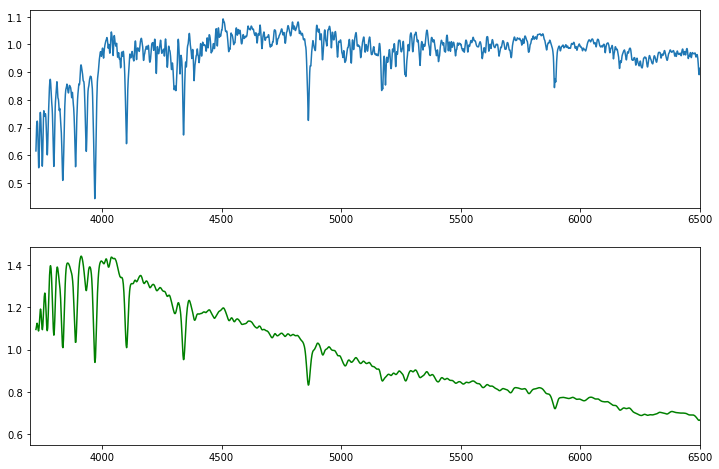

In [33]:
figsize(12,8)
temp=umspektra[0]
figure(1)
plt.subplot(211)
plot(atlagsp[:,0],atlagsp[:,1])
xlim(3700,6500)
plt.subplot(212)
plot(temp[:,0],temp[:,1],'g')
xlim(3700,6500)

In [34]:
red_umspektra={}
for j in range (0,i):
    temp=umspektra[j]
    for k in range (0,5062):
        temp[k,1]=temp[k,1]-atlagsp[k,1]
    red_umspektra[j]=temp
    del temp
del umspektra

In [35]:
Trafomtx=numpy.dot(eig.T,eig)
print(Trafomtx)

[[  1.00000000e+00   4.23272528e-16  -2.67147415e-16   3.43475248e-16
    1.86916455e-16]
 [  4.23272528e-16   1.00000000e+00  -3.57353036e-16  -5.68121938e-16
   -2.46764414e-16]
 [ -2.67147415e-16  -3.57353036e-16   1.00000000e+00   7.27716498e-16
   -3.43692089e-16]
 [  3.43475248e-16  -5.68121938e-16   7.27716498e-16   1.00000000e+00
   -4.85288892e-16]
 [  1.86916455e-16  -2.46764414e-16  -3.43692089e-16  -4.85288892e-16
    1.00000000e+00]]


In [36]:
Kifejteseh={}
for j in range (0,i):
    temp=red_umspektra[j]
    A=numpy.dot(inv(Trafomtx),eig.T)
    PC=numpy.dot(A,temp[:,1])
    Kifejteseh[j]=PC
    del PC
    del temp
    del A

# Kontinuumok legenerálása a középpontokra

Legenerálom az egyes középpontokra a kontinuumokat

In [37]:
centr=centr40.T         # most az oszlopokban lesznek az egyes centrumokhoz tartozó együtthatók
for j in range (0,5):
    for i in range (0,40):
        centr[j,i]=centr[j,i]*szorasok[j]

In [38]:
kpspektra={}
for i in range (0,40):
    spektrum=numpy.empty((5062,2))
    temp=centr[:,i]
    spektrum[:,0]=mintapontok[:]
    spektrum[:,1]=numpy.dot(eig,temp)+atlagsp[:,1]
    kpspektra[i]=spektrum
    del spektrum
    del temp

Ábrázolom az egyiket a biztoság kedvéért

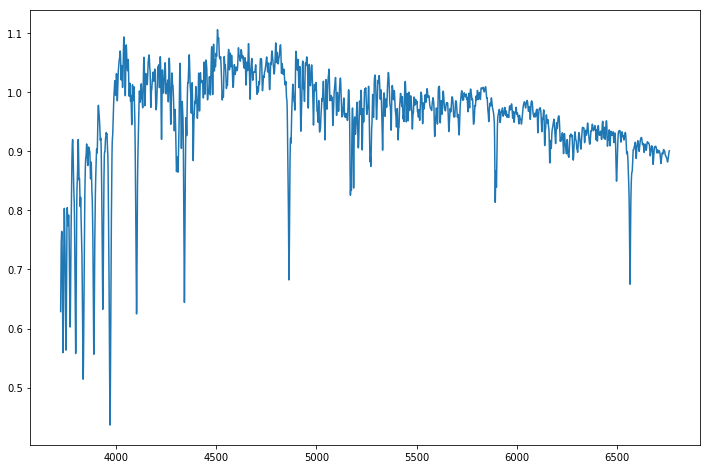

In [39]:
temp=kpspektra[0]
plot(temp[:,0],temp[:,1])
del temp

# Kovarianciamátrix, kék galaxis választása

Ezek után kéne a kovarianciamátrixokat összehozni. Ehhez kellenek az egyes klaszterekhez tartozó pontok külön külön, szóval szortírozni kell a labelek szerint.

In [40]:
lab_emiss=numpy.empty((11,13787))        # hány sora van és hány oszlopa
lab_emiss[0,:]=labels40[:]               # első sorban vannak az indexek, tehát az oszlopok tartoznak a különálló gx-okhoz
lab_emiss[1:11,:]=PCemiss[:,:] 

In [41]:
kpemi={}                 # a dictionary egyes logjai az egyes középpont környezetébe eső pontok lesznek emissziós vonalak terében
for i in range (0,40):
    n=0
    for j in range (0,13787):
        if(lab_emiss[0,j]==i):
            n+=1
    temp=numpy.empty((10,n))
    m=0
    for j in range (0,13787):
        if(lab_emiss[0,j]==i):
            temp[:,m]=lab_emiss[1:11,j]
            m+=1
    kpemi[i]=temp
    del temp

Akkor tehát megvan a szortírozás, az egyes kontinuumok is, tehát már csak le kell generálni az egyes kovarianciamátrixokat, majd a véletlen számokat kell keresgélni, **NE FELEDD,** az oszlopokban vannak az egyes galaxisokhoz tartozó együtthatók

In [42]:
kovarianc={}
means={}
for i in range (0,40):
    temp=kpemi[i]
    meant=numpy.mean(temp,axis=1)
    temp -= temp.mean(axis=1)[:, None]
    covi=numpy.cov(temp)
    kovarianc[i]=covi
    means[i]=meant
    del covi
    del temp
    del meant

In [43]:
numpy.save('./PCAfeldolgozas/klaszt_means.npy',means)
numpy.save('./PCAfeldolgozas/klaszt_kovar.npy',kovarianc)

Most kéne egy kék galaxist választani. Ehhez plottolom a galaxisokat az első két főkomponensükkel asszerint színezve, mennyire kékek

In [27]:
PCs=PCs.T
elso2=PCs[:,0:2]

A következő fájlban vannak ezek lementve, beolvasom, majd kiveszem a g és r sávhoz tartozó magnikat, ezeket kivonom egymásból, lenormálom és ezt próbálom majd színkódolni

In [28]:
data=loadtxt('emisslines.txt')
gr=numpy.empty((13787,2))
gr[:,0]=data[:,2]
gr[:,1]=data[:,3]

In [29]:
g_r=numpy.empty((13787,1))
g_r[:,0]=gr[:,0]-gr[:,1]

In [30]:
normgr=g_r[:,0]
maxim=max(g_r[:,0])
s=100/maxim
normgr=s*normgr
print(normgr)

[ 10.79141573   6.94376113  22.67028586 ...,  16.73085079   7.80218848
   6.83009585]


In [31]:
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'brg'

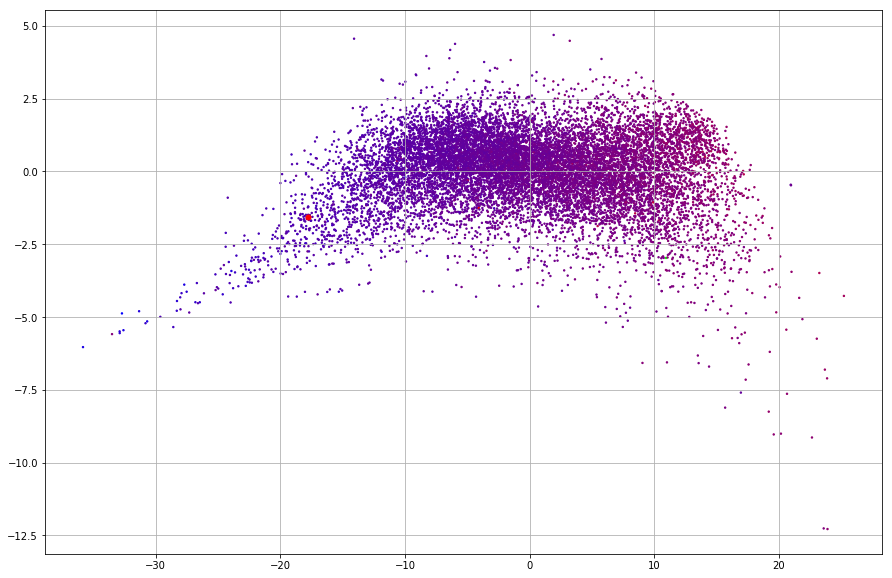

In [32]:
figsize(15,10)
x=elso2[:,0]
y=elso2[:,1]
plt.scatter(x,y,c=normgr,s=2)
grid(True)
temp=Kifejteseh[0]
plot(temp[0],temp[1],'ro',ms=5)
# plot(centr[0,33],centr[1,33],'bo',ms=5)

Pár pontra amit kiprinteltem megnéztem, ha kisebb az első két együttható, akkor nagyobb a g-r, azaz kékebb lesz a galaxis. Tehát nekünk az a centroid kell, aminek az első eh-ja <-10 és a második < 0. Ha megnézem a korábbi ábrázolgatásokat, akkor kb 5-6 ilyen centroid van

In [33]:
#for i in range (0,40):
#    if(centr[0,i]<(-10) and centr[1,i]<0):
#        print(i)

Tehát akkor most ezt a kontinuumot kell majd nyúzni egy kicsit: erre kell majd vonalakat generálni, meg nézni a szín szín diagramot. Először megcsinálom azt, hogy generálok rá vonalakat, majd azt tologatom el, és majd ez után próbálom meg azt, hogy minden redshiften új vonalakat dobálok rá.

# Legközelebbi szomszéd keresése a templatehez

In [34]:
tavolsagok={}
for l in range (0,40):
    tavolsagok[l]=0
    temp=0
    teh=Kifejteseh[0]
    for m in range (0,5):
        temp+=(teh[m]-centr[m,l])**2
    tavolsagok[l]=sqrt(temp)
    del temp
minimal=30
for l in range (0,40):
    temp=tavolsagok[l]
    if(temp<minimal):
        minimal=temp
        I=l
    del temp
print(I)
ind=I
del I

9


Ezzel tehát megvan a legközelebbi centroid indexe, már csak az kell, hogy ehhez generáljuk a vonalakat.

# Vonalak generálása

Tehát akkor most az kéne, hogy ne egy emissziós vonalat generáljak, hanem minden redshift esetére rajzoljak fel többet, azaz többet kéne húzni és meg kéne nézni, hova szóródnak

Első körben ugye meg kell csináli az egészet a kontinuumra, azt ugyanúgy mint korábban

# Kontinuumra tisztán

In [35]:
from scipy.integrate import trapz

In [49]:
V=numpy.load('./PCAfeldolgozas/EmissV.npy')
atlag=numpy.load('./PCAfeldolgozas/emissatlag.npy')

In [37]:
for j in range (0,1):
    temp=kompozit
    m1=0
    m2=0
    m3=0
    m4=0
    n=0
    for k in temp[:,0]:
        if(k>4250 and k<4300):
            if(m1==0):
                normalashoz1=temp[n,1]
                m1+=1
            else:
                normalashoz1=numpy.append(normalashoz1,temp[n,1])
                
        if(k>4600 and k<4800):
            if(m2==0):
                normalashoz2=temp[n,1]
                m2+=1
            else:
                normalashoz2=numpy.append(normalashoz2,temp[n,1])
                
        if(k>5400 and k<5500):
            if(m3==0):
                normalashoz3=temp[n,1]
                m3+=1
            else:
                normalashoz3=numpy.append(normalashoz3,temp[n,1])
                
        if(k>5600 and k<5800):
            if(m4==0):
                normalashoz4=temp[n,1]
                m4+=1
            else:
                normalashoz4=numpy.append(normalashoz4,temp[n,1])
                
        n+=1
        
    med1=numpy.median(normalashoz1)
    med2=numpy.median(normalashoz2)
    med3=numpy.median(normalashoz3)
    med4=numpy.median(normalashoz4)
    avgmed=(med1+med2+med3+med4)/4
        
    temp[:,1]=temp[:,1]/avgmed
    Kontinuum=temp
    del temp

In [38]:
mintapontok=linspace(1001,14999,27997)
temp=Kontinuum
umspektrum=numpy.interp(mintapontok,temp[:,0],temp[:,1])  # a mintavételezésre immáron a numpy-os interpolációt használom
Kontinuum_res=numpy.vstack((mintapontok,umspektrum)).T
del temp
UmSp={}
UmSp[0]=Kontinuum_res

In [39]:
import os
import codecs
indir = './SDSS/Filters'
szurok={}
for root, dirs, filenames in os.walk(indir):
    i=0
    for f in filenames:
        filecp = codecs.open(os.path.join(root, f), encoding = 'cp1252')
        content = loadtxt(filecp)
        array=content
        szurok[i]=array
        i+=1
        del content
        del array
# print(szurok)

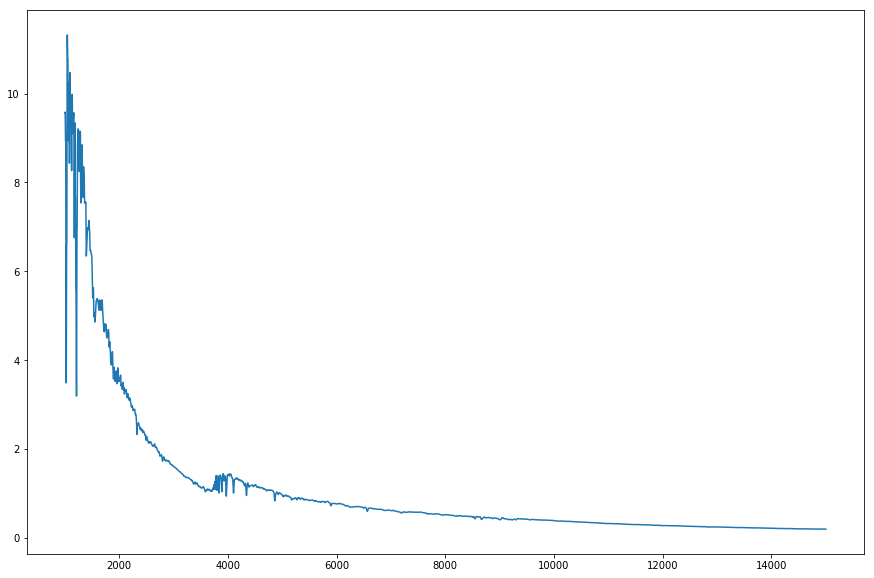

In [40]:
plot(Kontinuum_res[:,0],Kontinuum_res[:,1])

In [41]:
# errorok miatt kénytelen voltam kézzel beadni az egyes szűrők elemszámát, próbáltam már elgé sok mindent...
umszurok={}
elemszam=[89,75,89]
z=0.0
u=0
Kmagnik=numpy.empty((71,4))
while(z<0.71):
    Kmagnik[u,0]=z
    Kontiz=numpy.empty((27997,2))
    for q in range (0,27997):
        Kontiz[:,0]=(1.0+z)*Kontinuum_res[:,0]
        Kontiz[:,1]=Kontinuum_res[:,1]
    
    # most kell újramintavételezni a szűrőt, ehhez behozom a már korábban megírt scriptet, mindegyik szűrőt újramintavételezem
    
    for j in range (0,3):       
        temp=szurok[j]
        umszuro_at=numpy.interp(Kontiz[:,0],temp[:,0],temp[:,1])

        umszuro=numpy.vstack((Kontiz[:,0], umszuro_at)).T
        umszurok[j]=umszuro
        
        vi=0
        for w in range (0,27997):
            if(umszuro_at[w]>0):
                    wk=w-vi
                    vi+=1
                    
        umszuror=umszuro[wk:wk+vi,:]
        Kontizr=Kontiz[wk:wk+vi,:]
        
    # ezekre az elnevezésekre semmi szükség, csak az ellenőrzések miatt neveztem el őket külön, aztán így maradtak...
    
        
        Ktempsz=numpy.multiply(Kontizr[:,1],umszuror[:,1])
        Ktempsz2=numpy.multiply(Ktempsz,Kontizr[:,0])
        Ktempsz2=Ktempsz2.tolist()
        Ktemplist=[1/x for x in Kontizr[:,0]]
        Ktempsz3=numpy.multiply(umszuror[:,1],Ktemplist)
        Ktempsz3=Ktempsz3.tolist()
            
        Kszamlalo=trapz(Ktempsz2,x=Kontizr[:,0]) 
        Knevezo=trapz(Ktempsz3,x=Kontizr[:,0])
        
        Kflux=Kszamlalo/Knevezo
        
        Kmab=-2.5*numpy.log10(Kflux)-48.60
        
        Kmagnik[u,j+1]=Kmab
        
    u+=1
    print(z)
    z+=0.01

0.0
0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.07
0.08
0.09
0.09999999999999999
0.10999999999999999
0.11999999999999998
0.12999999999999998
0.13999999999999999
0.15
0.16
0.17
0.18000000000000002
0.19000000000000003
0.20000000000000004
0.21000000000000005
0.22000000000000006
0.23000000000000007
0.24000000000000007
0.25000000000000006
0.26000000000000006
0.2700000000000001
0.2800000000000001
0.2900000000000001
0.3000000000000001
0.3100000000000001
0.3200000000000001
0.3300000000000001
0.34000000000000014
0.35000000000000014
0.36000000000000015
0.37000000000000016
0.38000000000000017
0.3900000000000002
0.4000000000000002
0.4100000000000002
0.4200000000000002
0.4300000000000002
0.4400000000000002
0.45000000000000023
0.46000000000000024
0.47000000000000025
0.48000000000000026
0.49000000000000027
0.5000000000000002
0.5100000000000002
0.5200000000000002
0.5300000000000002
0.5400000000000003
0.5500000000000003
0.5600000000000003
0.5700000000000003
0.5800000000000003
0.5900000000000003
0.6

# Átlag emissziós vonalakkal történő futtatás

In [50]:
avg=means[ind]
lambd=[3727,4342,4863,4960,5008,6550,6565,6585,6718,6733]
elemszam=[89,75,89]

from scipy.integrate import quad

def integrand(x, sig, l0):
    return(numpy.exp(-(x-l0)**2 / (2*sig**2)))

nminta=27997                  # mintavételezési helyek száma
sigma=200                     # gx sebsségdiszperziója  <----- EZ MÉG MINDIG CSAK EGY ÖNKÉNYES PARAMÉTER


vonaleh=avg

z=0.0
u=0
Amagnik=numpy.empty((351,4))
while(z<0.702):
    Amagnik[u,0]=z
    
    logEWred=numpy.dot(V.T,vonaleh)                   # ezekre számoljuk a log EW-ket
    logEWk=logEWred+atlag[:,1]
    EW=numpy.exp(logEWk)
    
    Spektrum=Kontinuum_res                    # a spektrumnak alapul a kontinuumot veszem
    
    tempK=UmSp[0]


    for j in range (0,10):
        l0=lambd[j]                   # emissziós vonal hullámhossza
        dellambd=l0*sigma/300000
        l1=l0-dellambd                # alsó integrálási határ
        l2=l0+dellambd                # felső integrálási határ
        sig=(l2-l0)/3                 # Gauss szórása
        W=EW[j]

        I=quad(integrand, l1, l2, args=(sig, l0))    # Gauss integrál számolása
    
        integ=I[0]                                   # quad több értékkel tér vissza, ebből veszem az elsőt

        F0=0
        w=0
        for q in range (0,nminta):
            if(tempK[q,0]>l1 and tempK[q,0]<l2):         # számolok egy átlagkontinuumot a vonal környezetében (a vonal alatt)
                F0+=tempK[q,1]
                w+=1
                
        F0=F0/w

        a=F0*W/integ                   # Gauss együtthatója

        Flamb=numpy.empty((1000,1))                                 # kiszámolom a csúcs fluxusait
        lamb=linspace(l1,l2,1000)
        for i in range (0,1000):
            Flamb[i]=F0+a*numpy.exp(-(lamb[i]-l0)**2 / (2*sig**2))
    
        vonal=numpy.empty((1000,2))
        vonal[:,0]=lamb[:]
        vonal[:,1]=Flamb[:,0]

        d=0
        for q in range (0,nminta):                                 # hány mintavételezési pont esik a vonal alá
            if(mintapontok[q]>l1 and mintapontok[q]<l2):
                d+=1
        temp=vonal
        v=0
        umvon_int=numpy.interp(mintapontok,temp[:,0],temp[:,1])
    
        t=0  
        for q in range (0,nminta):                               # ráteszem a vonalat a spektrumra
            if(tempK[q,0]>l1 and tempK[q,0]<l2):
                Spektrum[q,1]+=umvon_int[t]
                t+=1      
                
        umvonal=numpy.vstack((mintapontok,umvon_int)).T
        del temp
        del vonal
        del umvonal
        del umvon_int
    del tempK

    temp=Kontinuum
    umspektrum=numpy.interp(mintapontok,temp[:,0],temp[:,1])
    Kontinuum_res=numpy.vstack((mintapontok,umspektrum)).T
    del temp
    
        # és akkor most kéne számolni a magnikat, és azokat belepakolni a dictionaryba



    Spekz=numpy.empty((27997,2))
    for q in range (0,27997):
        Spekz[:,0]=(1.0+z)*Spektrum[:,0]           # vöröseltolódást szenvedett spektrum
        Spekz[:,1]=Spektrum[:,1]                   # fluxusok ua-zok, csak odébb lettek tolva
    
        # most kell újramintavételezni a szűrőt, ehhez behozom a már korábban megírt scriptet, mindegyik szűrőt újramintavételezem
    
    for j in range (0,3):       
        temp=szurok[j]
        umszuro_at=numpy.interp(Spekz[:,0],temp[:,0],temp[:,1])

        umszuro=numpy.vstack((Spekz[:,0], umszuro_at)).T
        
        vi=0
        for w in range (0,27997):
            if(umszuro_at[w]>0):
                    wk=w-vi
                    vi+=1
                        
        Spekzr=Spekz[wk:wk+vi,:]
        umszuror=umszuro[wk:wk+vi,:]
        
    # ezekre az elnevezésekre semmi szükség, csak az ellenőrzések miatt neveztem el őket külön, aztán így maradtak...
    
    # azért van ennyi elnevezés, mert egyszerre akarom a futtatást a kontinuumra és a vonalas spektrumra
        Atempsz=numpy.multiply(Spekzr[:,1],umszuror[:,1])
        Atempsz2=numpy.multiply(Atempsz,Spekzr[:,0])
        Atempsz2=Atempsz2.tolist()
        Atemplist=[1/x for x in Spekzr[:,0]]
        Atempsz3=numpy.multiply(umszuror[:,1],Atemplist)
        Atempsz3=Atempsz3.tolist()
        
        Aszamlalo=trapz(Atempsz2,x=Spekzr[:,0])
        Anevezo=trapz(Atempsz3,x=Spekzr[:,0])
        
        Aflux=Aszamlalo/Anevezo
        
        Amab=-2.5*numpy.log10(Aflux)-48.60
        
        Amagnik[u,j+1]=Amab
        
    z+=0.002
    u+=1

# Emissziós vonalak húzása és az azokra történő futtatás

Minden redshiften más-más vonalakat huzigálunk, úgy nézzük a szórást, elméletileg a ciklusok jók, csak ki kéne tenni az elejére a while(z)-t, valamint van benne egy-két új array generálás, azokat ki kéne dobálni. Legyen az, hogy a redshifteken sorban megy végig, kívül van az hogy hányszor akarunk végigmenni, és csak felhozzuk a redshiftre futó ciklust a tetejére

In [43]:
cov=kovarianc[ind]
avg=means[ind]
lambd=[3727,4342,4863,4960,5008,6550,6565,6585,6718,6733]
elemszam=[89,75,89]

from scipy.integrate import quad

def integrand(x, sig, l0):
    return(numpy.exp(-(x-l0)**2 / (2*sig**2)))

nminta=27997                  # mintavételezési helyek száma
sigma=200                     # gx sebsségdiszperziója  <----- EZ MÉG MINDIG CSAK EGY ÖNKÉNYES PARAMÉTER

del z

# emisszivon={}      # ebbe fogom tárolni az egyes magnikat az egyes vonalhúzásokra

N=7000               # 10 vonalhúzás legyen minden redhisften
Smagnik=numpy.empty((N,4))
for r in range (0,N):
    # z=0.0
    # u=0
 #    Smagnik=numpy.empty((71,4))
 #   while(z<0.71):
    z=random.uniform(0,0.70)              # a redshiftek random jönnek egymás után, ezt gyorsan vissza lehet írni arra, hogy ugyanazon spektrumokat tologassa
    Smagnik[r,0]=z
    
    vonaleh=numpy.random.multivariate_normal(avg,cov) # első lépésként vonaleh-kat generálunk
    logEWred=numpy.dot(V.T,vonaleh)                   # ezekre számoljuk a log EW-ket
    logEWk=logEWred+atlag[:,1]
    EW=numpy.exp(logEWk)
    
    Spektrum=Kontinuum_res                    # a spektrumnak alapul a kontinuumot veszem
    
    tempK=UmSp[0]


    for j in range (0,10):
        l0=lambd[j]                   # emissziós vonal hullámhossza
        dellambd=l0*sigma/300000
        l1=l0-dellambd                # alsó integrálási határ
        l2=l0+dellambd                # felső integrálási határ
        sig=(l2-l0)/3                 # Gauss szórása
        W=EW[j]

        I=quad(integrand, l1, l2, args=(sig, l0))    # Gauss integrál számolása
    
        integ=I[0]                                   # quad több értékkel tér vissza, ebből veszem az elsőt

        F0=0
        w=0
        for q in range (0,nminta):
            if(tempK[q,0]>l1 and tempK[q,0]<l2):         # számolok egy átlagkontinuumot a vonal környezetében (a vonal alatt)
                F0+=tempK[q,1]
                w+=1
                
        F0=F0/w

        a=F0*W/integ                   # Gauss együtthatója

        Flamb=numpy.empty((1000,1))                                 # kiszámolom a csúcs fluxusait
        lamb=linspace(l1,l2,1000)
        for i in range (0,1000):
            Flamb[i]=F0+a*numpy.exp(-(lamb[i]-l0)**2 / (2*sig**2))
    
        vonal=numpy.empty((1000,2))
        vonal[:,0]=lamb[:]
        vonal[:,1]=Flamb[:,0]

        d=0
        for q in range (0,nminta):                                 # hány mintavételezési pont esik a vonal alá
            if(mintapontok[q]>l1 and mintapontok[q]<l2):
                d+=1
        temp=vonal
        v=0
        umvon_int=numpy.interp(mintapontok,temp[:,0],temp[:,1])
    
        t=0  
        for q in range (0,nminta):                               # ráteszem a vonalat a spektrumra
            if(tempK[q,0]>l1 and tempK[q,0]<l2):
                Spektrum[q,1]+=umvon_int[t]
                t+=1      
            
        umvonal=numpy.vstack((mintapontok,umvon_int)).T
        del temp
        del vonal
        del umvonal
        del umvon_int
    del tempK

    temp=Kontinuum
    umspektrum=numpy.interp(mintapontok,temp[:,0],temp[:,1])
    Kontinuum_res=numpy.vstack((mintapontok,umspektrum)).T
    del temp
    
        # és akkor most kéne számolni a magnikat, és azokat belepakolni a dictionaryba



    Spekz=numpy.empty((27997,2))
    for q in range (0,27997):
        Spekz[:,0]=(1.0+z)*Spektrum[:,0]           # vöröseltolódást szenvedett spektrum
        Spekz[:,1]=Spektrum[:,1]                   # fluxusok ua-zok, csak odébb lettek tolva
    
    # most kell újramintavételezni a szűrőt, ehhez behozom a már korábban megírt scriptet, mindegyik szűrőt újramintavételezem
    
    for j in range (0,3):       
        temp=szurok[j]
        umszuro_at=numpy.interp(Spekz[:,0],temp[:,0],temp[:,1])

        umszuro=numpy.vstack((Spekz[:,0], umszuro_at)).T
        
        vi=0
        for w in range (0,27997):
            if(umszuro_at[w]>0):
                    wk=w-vi
                    vi+=1
                        
        Spekzr=Spekz[wk:wk+vi,:]
        umszuror=umszuro[wk:wk+vi,:]
        
    # ezekre az elnevezésekre semmi szükség, csak az ellenőrzések miatt neveztem el őket külön, aztán így maradtak...
    
    # azért van ennyi elnevezés, mert egyszerre akarom a futtatást a kontinuumra és a vonalas spektrumra
        Stempsz=numpy.multiply(Spekzr[:,1],umszuror[:,1])
        Stempsz2=numpy.multiply(Stempsz,Spekzr[:,0])
        Stempsz2=Stempsz2.tolist()
        Stemplist=[1/x for x in Spekzr[:,0]]
        Stempsz3=numpy.multiply(umszuror[:,1],Stemplist)
        Stempsz3=Stempsz3.tolist()
        
        Sszamlalo=trapz(Stempsz2,x=Spekzr[:,0])
        Snevezo=trapz(Stempsz3,x=Spekzr[:,0])
        
        Sflux=Sszamlalo/Snevezo
        
        Smab=-2.5*numpy.log10(Sflux)-48.60
        
        Smagnik[r,j+1]=Smab
        
  #      z+=0.01
  #      u+=1
  #  emisszivon[r]=Smagnik

In [64]:
print(Amagnik)

[[  0.00000000e+00  -6.70706595e+01  -6.72768064e+01  -6.73453349e+01]
 [  2.00000000e-03  -6.70739724e+01  -6.72776172e+01  -6.73484284e+01]
 [  4.00000000e-03  -6.70772745e+01  -6.72782739e+01  -6.73516715e+01]
 ..., 
 [  6.96000000e-01  -6.76356362e+01  -6.77719908e+01  -6.81707291e+01]
 [  6.98000000e-01  -6.76381530e+01  -6.77716427e+01  -6.81722029e+01]
 [  7.00000000e-01  -6.76406664e+01  -6.77713274e+01  -6.81737597e+01]]


In [3]:
Amagnik=numpy.load('amagnikblue.npy')
Smagnik=numpy.load('smagnikblue.npy')

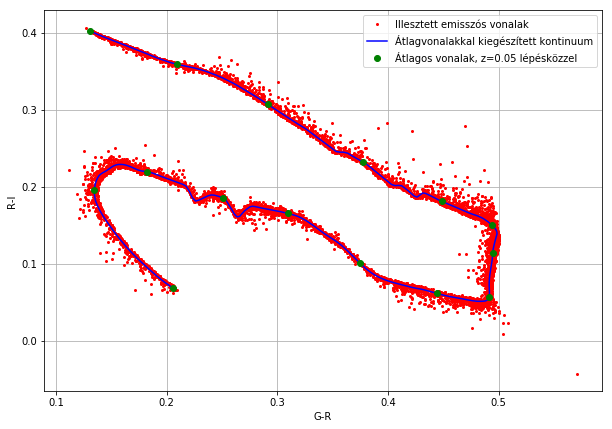

In [8]:
figsize(10,7)
#GRk=Kmagnik[:,1]-Kmagnik[:,2]
#RIk=Kmagnik[:,2]-Kmagnik[:,3]

#temp=emisszivon[0]

#GRv=temp[:,1]-temp[:,2]
#RIv=temp[:,2]-temp[:,3]
#del temp
GRv=Smagnik[:,1]-Smagnik[:,2]
RIv=Smagnik[:,2]-Smagnik[:,3]
emi=plot(GRv,RIv,'ro',ms=2,label='Illesztett emisszós vonalak')
#for g in range (1,N):
#    temp=emisszivon[g]
#    GRv=temp[:,1]-temp[:,2]
#    RIv=temp[:,2]-temp[:,3]
#    plot(GRv,RIv,'ro',ms=3)
#    del temp

GRa=Amagnik[:,1]-Amagnik[:,2]
RIa=Amagnik[:,2]-Amagnik[:,3]
numpy.save('amagnikblue.npy',Amagnik)
#konti=plot(GRk,RIk,label='Kompozithoz tartozó kontinuum')
atlag=plot(GRa,RIa,color='blue',label='Átlagvonalakkal kiegészített kontinuum')
grid(True)
#konti10=plot(GRk[0],RIk[0],'bo',label='Kontinuum, z=0.1-enként')
atlag10=plot(GRa[0],RIa[0],'go',label='Átlagos vonalak, z=0.05 lépésközzel')
for r in range (1,15):
    #plot(GRk[10*r],RIk[10*r],'bo')
    plot(GRa[25*r],RIa[25*r],'go')
xlabel('G-R')
ylabel('R-I')
plt.legend()
#savefig('1blue_soras7000nk_szsz.pdf', bbox_inches='tight')

In [68]:
numpy.save('smagnikblue.npy',Smagnik)

In [45]:
#interpolate, elemenkénti szorzás, scipy integrate trapz

SyntaxError: invalid syntax (<ipython-input-45-2335eb624585>, line 1)

# BPT diagram

In [ ]:
for i in range (0,13787):
    